# 1. 選定三個粉絲頁：
#####  100489613340306 SAMSUNG Mobile Taiwan
#####  131307770301236 WATSONS Taiwan
#####  203507002993446 PChome

In [1]:
fanpage=['100489613340306','131307770301236','203507002993446']

# 2. 統計該三個粉絲頁的基本資訊，包含：start date time, end date time, # of fans、# of posts、# of likes、like from unique users、comment from unique user、

In [2]:
 # -*- coding: utf-8 -*-
import pyes
import elasticsearch
import json

In [3]:
# Connecting to elasticsearch server
es_address='140.118.109.114:9200'
conn = pyes.es.ES(es_address)
conn.default_indices=["facebook_nested"]

In [4]:
# doc_types: fanpage,post,like,comment
def query(fid,doc_types):
    tq = pyes.query.TermQuery(field="fid",value=fid)
    qsearch = pyes.query.Search(tq,size=5000)
    result = conn.search(query=qsearch , doc_types=doc_types,size=5000)
    return result

In [5]:
def query_agg(fid,doc_types,agg_field):
    tq = pyes.query.TermQuery(field="fid",value=fid)
    tagg_comment = pyes.aggs.TermsAgg('genres',field=agg_field,size=0)
    qsearch = pyes.query.Search(tq)
    qsearch.agg.add(tagg_comment)
    result = conn.search(query=qsearch , doc_types=doc_types)
    return result

In [6]:
# initialize fanpage object with fanpage id and fanpage source from es/fanpage
class fanpage:
    def __init__(self, fid):
        self.fid=fid
    def name(self):
        return query(self.fid,"fanpage").hits[0]['_source']['name']
    def num_fans(self):
        return query(self.fid,"fanpage").hits[0]['_source']['likes_count']
    def num_posts(self):
        return query(self.fid,"post").total
    def num_likes(self):
        return query(self.fid,"like").total
    def num_comments(self):
        return query(self.fid,"comment").total
    def num_user_like(self):
        result = query_agg(self.fid,"like","uid")
        return len(result.aggs['genres']['buckets'])
    def num_user_comment(self):
        result = query_agg(self.fid,"comment","from.name")
        return len(result.aggs['genres']['buckets'])

In [7]:
fp_samsung = fanpage('100489613340306')
fp_watsons = fanpage('131307770301236')
fp_pchome = fanpage('203507002993446')

In [92]:
print "name:", fp_samsung.name()
print '# of fans:', fp_samsung.num_fans()
print '# of posts:', fp_samsung.num_posts()
print '# of likes:', fp_samsung.num_likes()
print 'like from unique users:', fp_samsung.num_user_like()
print 'comment from unique user:',fp_samsung.num_user_comment()

name: Samsung Mobile Taiwan
# of fans: 1025150
# of posts: 4238
# of likes: 7719913
like from unique users: 1257243
comment from unique user: 100625


In [93]:
print "name:", fp_watsons.name()
print '# of fans:', fp_watsons.num_fans()
print '# of posts:', fp_watsons.num_posts()
print '# of likes:', fp_watsons.num_likes()
print 'like from unique users:', fp_watsons.num_user_like()
print 'comment from unique user:',fp_watsons.num_user_comment()

name: 屈臣氏 Watsons Taiwan
# of fans: 790929
# of posts: 4006
# of likes: 2474094
like from unique users: 572494
comment from unique user: 69319


In [94]:
print "name:", fp_pchome.name()
print '# of fans:', fp_pchome.num_fans()
print '# of posts:', fp_pchome.num_posts()
print '# of likes:', fp_pchome.num_likes()
print 'like from unique users:', fp_pchome.num_user_like()
print 'comment from unique user:',fp_pchome.num_user_comment()

name: PChome 24h購物
# of fans: 254630
# of posts: 3597
# of likes: 1595130
like from unique users: 372027
comment from unique user: 78992


# 3. 三個粉絲頁box plot against to the # of comments for each post

In [10]:
#print samsung_comment_count.hits[0]['_source']['comment_count'] 取用termquery拿回來的東西

In [11]:
#print len(samsung_comment_count.hits)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def num_comment_on_post(fid):
    result = []
    es_post = query(fid,'post')
    for post in es_post.hits:
        result.append(post['_source']['comment_count'])
    return result

In [14]:
list_samsung_box= num_comment_on_post('100489613340306')

In [15]:
list_watsons_box= num_comment_on_post('131307770301236')

In [16]:
list_pchome_box= num_comment_on_post('203507002993446')

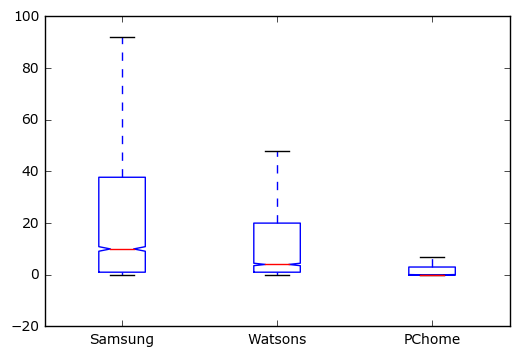

In [17]:
# exclue outlier
plt.figure()
plt.boxplot([list_samsung_box,list_watsons_box,list_pchome_box],2,'')
plt.xticks([1,2,3],['Samsung','Watsons','PChome'])
plt.show()

# 4. 三個粉絲頁個別的 (#) of post,  (# /  ratio) of post with sharing,  (# / ratio) of post with friend tagging 

In [18]:
import pandas as pd

In [19]:
# 輸入fanpage id 回傳全部fid_pid
def get_all_post_id(fid):
    result = []
    es_post = query(fid,'post')
    for post in es_post.hits:
        result.append(post['_source']['id'])
    return result

In [20]:
# 輸入fid_pid 回傳share_count
def get_share_count(fid_pid):
    tq = pyes.query.TermQuery(field="_id",value=fid_pid)
    qsearch = pyes.query.Search(tq)
    result = conn.search(query=qsearch , doc_types="post")
    return result.hits[0]["_source"]['shares']['count']

In [21]:
# 輸入fid 回傳由fid, share_count組合而成的0維list
def make_table(fid):
    result = []
    all_fid_pid = get_all_post_id(fid)
    for fid_pid in all_fid_pid:
        try:
            share_count = get_share_count(fid_pid)
        except:
            share_count = np.NaN
        result.append([fid_pid,share_count])
    return result

In [22]:
tmp = make_table('203507002993446')

In [23]:
# 使用np.array轉成二維ndarray
np_tmp = np.array(tmp)

In [24]:
np_tmp.shape

(3597, 2)

In [25]:
np_tmp

array([[u'203507002993446_1165621306782006', u'nan'],
       [u'203507002993446_1003217163022422', u'4'],
       [u'203507002993446_846903141987159', u'nan'],
       ..., 
       [u'203507002993446_1202963469714456', u'1'],
       [u'203507002993446_1198770016800468', u'7'],
       [u'203507002993446_1195610553783081', u'nan']], 
      dtype='<U33')

In [26]:
pd.DataFrame(data=np_tmp,columns=['fid_pid','share_count']).iloc[0:10]

,fid_pid,share_count
0,203507002993446_1165621306782006,nan
1,203507002993446_1003217163022422,4
2,203507002993446_846903141987159,nan
3,203507002993446_853586914652115,1
4,203507002993446_850690228275117,51
5,203507002993446_849875501689923,1
6,203507002993446_847899108554229,1
7,203507002993446_847492885261518,nan
8,203507002993446_1043738908970247,8
9,203507002993446_1004111512932987,1


# 5. 各個粉絲頁每月po文的comment變化(max, min, mean)

In [27]:
# 輸入fid 回傳es_multi aggregation結果
def get_comment_by_month(fid):
    q = pyes.query.TermQuery(field="fid",value=fid)
    tagg = pyes.aggs.DateHistogramAgg('post_over_time', field= 'created_time',interval="1M",format="yyyy-MM-dd'T'HH:mm:ssZZZZZ",sub_aggs=[])
    tagg1= pyes.aggs.TermsAgg('comment_over_post',field='fid_pid',size=5000)
    tagg.sub_aggs.append(tagg1)
    qsearch = pyes.query.Search(q)

    qsearch.agg.add(tagg)
    es_result = conn.search(query=qsearch , doc_types='comment') 
    return es_result

In [116]:
# 輸入第一層脫殼結果post_over_time，回傳dict by month{"month":XXXX,"count":123,12,11,12...}
def dict_per_month(bucket_month):
    dict_result = {}
    dict_result['month']=bucket_month['key_as_string']
    dict_result['count']=[]
    for comment in bucket_month['comment_over_post']['buckets']:
        dict_result['count'].append(comment['doc_count'])
    if len(dict_result['count'])==0:
        dict_result['count'].append(0)
    return dict_result

In [117]:
# 輸入fid, 回傳list 包含該fanpage的所有dict by month
def list_comment_month(fid):
    list_result = []
    es_result = get_comment_by_month(fid)
    for bucket_month in es_result.aggs['post_over_time']['buckets']:
        dict_result = dict_per_month(bucket_month)
        list_result.append(dict_result)
    return list_result 

In [107]:
samsung_comment_monthly = list_comment_month('100489613340306')
watsons_comment_monthly = list_comment_month('131307770301236')

In [118]:
pchome_comment_monthly = list_comment_month('203507002993446')

In [31]:
def tick_data(dict_monthly):
    result = []
    for i in dict_monthly:
        result.append(i['count'])
    return result

In [32]:
def tick_label(dict_monthly):
    result = []
    for i in dict_monthly:
        result.append(i['month'][0:10])
    return result

In [33]:
plt.figure(figsize=(15,10),num="Samsung")
plt.boxplot(tick_data(samsung_comment_monthly),0,"")
plt.xticks([x+1 for x in range(len(samsung_comment_monthly))],tick_label(samsung_comment_monthly),rotation='vertical')
plt.ylabel("# of comment per post",fontsize=15)
plt.title("SAMSUNG",fontsize=30)
#plt.show()

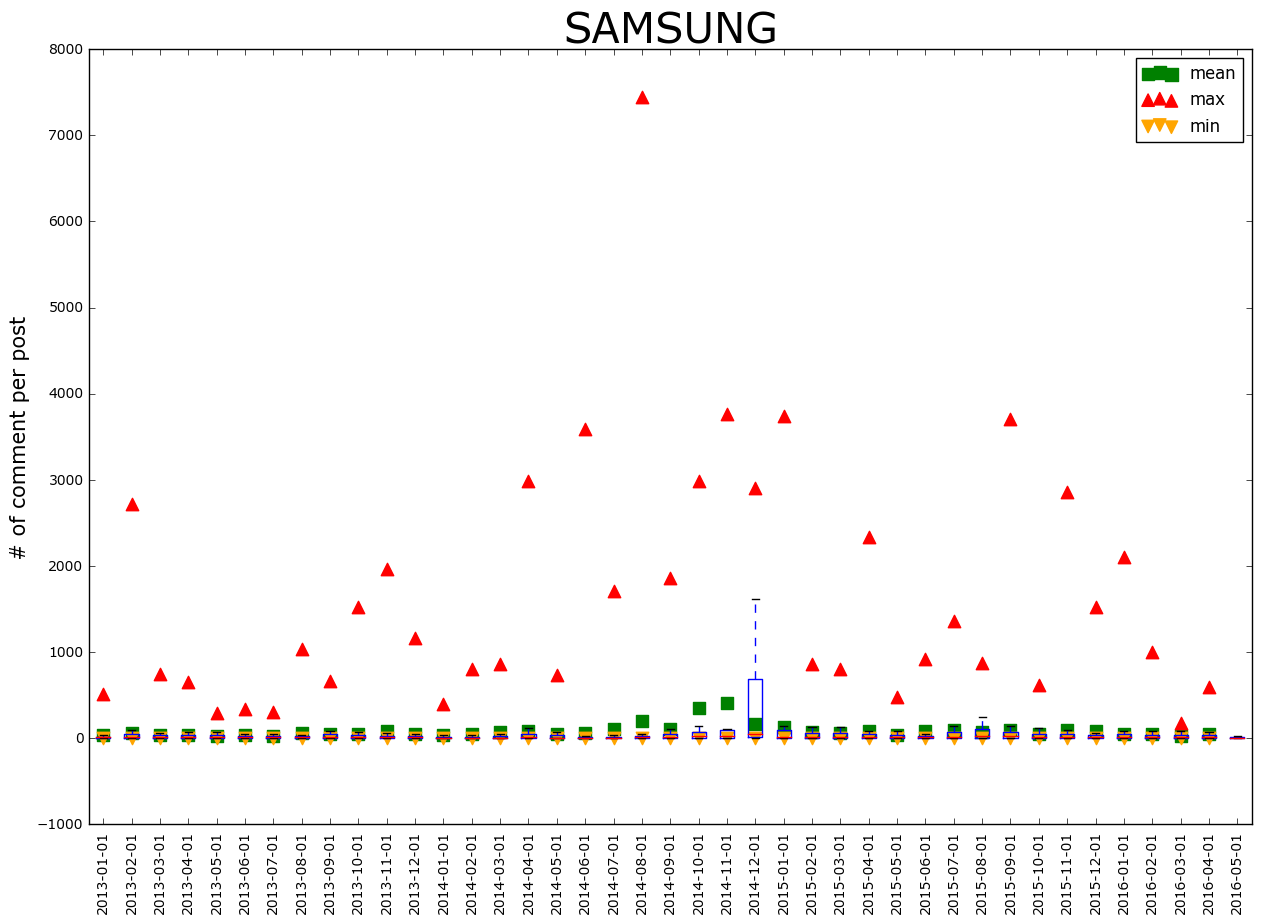

In [34]:
l = tick_data(samsung_comment_monthly)
for i in range(len(l)):
    lo=plt.scatter(i,sum(l[i])/len(l[i]),label="mean",marker="s",color="green",s=80)
    ll=plt.scatter(i,max(l[i]),marker="^",color="red",s=80)
    a=plt.scatter(i,min(l[i]),marker="v",color="orange",s=80)
plt.legend((lo,ll,a),('mean','max','min'),loc='best')
plt.show()

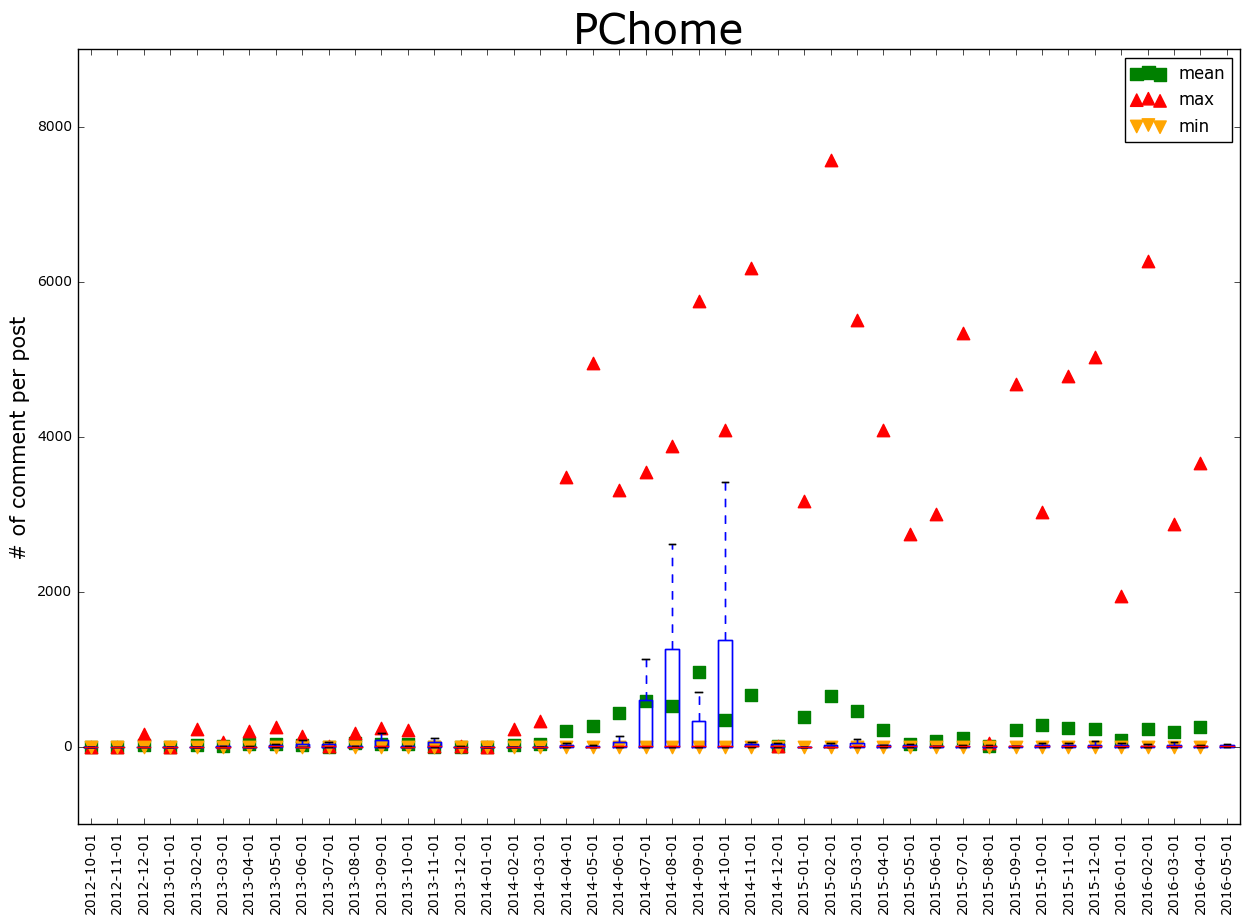

In [119]:
plt.figure(figsize=(15,10),num="PChome")
plt.boxplot(tick_data(pchome_comment_monthly),0,"")
plt.xticks([x+1 for x in range(len(pchome_comment_monthly))],tick_label(pchome_comment_monthly),rotation='vertical')
plt.ylabel("# of comment per post",fontsize=15)
plt.title("PChome",fontsize=30)

l = tick_data(pchome_comment_monthly)
for i in range(len(l)):
    lo=plt.scatter(i,sum(l[i])/len(l[i]),label="mean",marker="s",color="green",s=80)
    ll=plt.scatter(i,max(l[i]),marker="^",color="red",s=80)
    a=plt.scatter(i,min(l[i]),marker="v",color="orange",s=80)
plt.legend((lo,ll,a),('mean','max','min'),loc='best')
plt.show()

# 6. 每個粉絲頁每月po文的like變化(max, min, mean)

In [35]:
# 輸入fid 回傳es_multi aggregation結果
def get_post_by_month(fid):
    q = pyes.query.TermQuery(field="fid",value=fid)
    tagg = pyes.aggs.DateHistogramAgg('post_over_time', field= 'created_time',interval="1M",format="yyyy-MM-dd'T'HH:mm:ssZZZZZ",sub_aggs=[])
    tagg1= pyes.aggs.TermsAgg('time_over_post',field='id',size=5000)
    tagg.sub_aggs.append(tagg1)
    qsearch = pyes.query.Search(q)

    qsearch.agg.add(tagg)
    es_result = conn.search(query=qsearch , doc_types='post') 
    return es_result

In [36]:
# 輸入第一層脫殼結果post_over_time，回傳dict by month{"month":XXXX,"fid_pid":123,12,11,12...}
def fidpid_dict_per_month(bucket_month):
    dict_result = {}
    dict_result['month']=bucket_month['key_as_string']
    dict_result['fid_pid']=[]
    for time in bucket_month['time_over_post']['buckets']:
        dict_result['fid_pid'].append(time['key'])
    return dict_result

In [37]:
# 輸入fid, 回傳list 包含該fanpage的所有dict by month
def list_fidpid_month(fid):
    list_result = []
    es_result = get_post_by_month(fid)
    for bucket_month in es_result.aggs['post_over_time']['buckets']:
        dict_result = fidpid_dict_per_month(bucket_month)
        list_result.append(dict_result)
    return list_result 

In [38]:
samsung_fidpid_monthly = list_fidpid_month('100489613340306')

In [39]:
# doc_types: fanpage,post,like,comment
def like_query(fid_pid):
    tq = pyes.query.TermQuery(field="id",value=fid_pid)
    qsearch = pyes.query.Search(tq,size=5000)
    result = conn.search(query=qsearch , doc_types="post",size=5000)
    return result.hits[0]['_source']['likes_count']

In [40]:
def list_like_month(list_fidpid_monthly):
    list_like_monthly = list_fidpid_monthly
    for i in list_like_monthly:
        like = []
        for j in i['fid_pid']:
            like.append(like_query(j))
        i['count']=like
    return list_like_monthly

In [41]:
samsung_like_monthly = list_like_month(samsung_fidpid_monthly)

In [42]:
tmp = tick_data(samsung_like_monthly)

In [43]:
plt.figure(figsize=(15,10))
plt.boxplot(tick_data(samsung_like_monthly),0,"")
plt.xticks([x+1 for x in range(len(samsung_like_monthly))],tick_label(samsung_like_monthly),rotation='vertical')
plt.ylabel("# of like per post",fontsize=15)
plt.title("SAMSUNG",fontsize=30)
#plt.show()